---
# Modelling Seasonality in Candy Production with SARIMAX


---

### Introduction
Seasonality is a deterministic source of non-stationarity common in real world data. We will build on the ARMA class of time series models by introducing SARIMA, a model that adds a seasonal-period based autoregressive and moving average term to model time series data with seasonality. We will go over each parameter and how each relates to their corresponding parameter in the ARIMA model. We will then use the *Box-Jenkins method* to fit our SARIMA model and introduce a *rolling forecast* to test our model accuracy. 



In [2]:
import math
import itertools
import pandas as pd
import numpy as np
from scipy.stats import boxcox, kurtosis, skew
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX



from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight') 
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

%matplotlib inline

In [3]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [6]:
df = pd.read_csv('catfish.csv')
#df = df.rename(columns={'observation_date': 'date', 'IPG3113N':'production'})
df.index = pd.DatetimeIndex(data= df.Date)
df = df.drop(columns=['Date'])
df.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


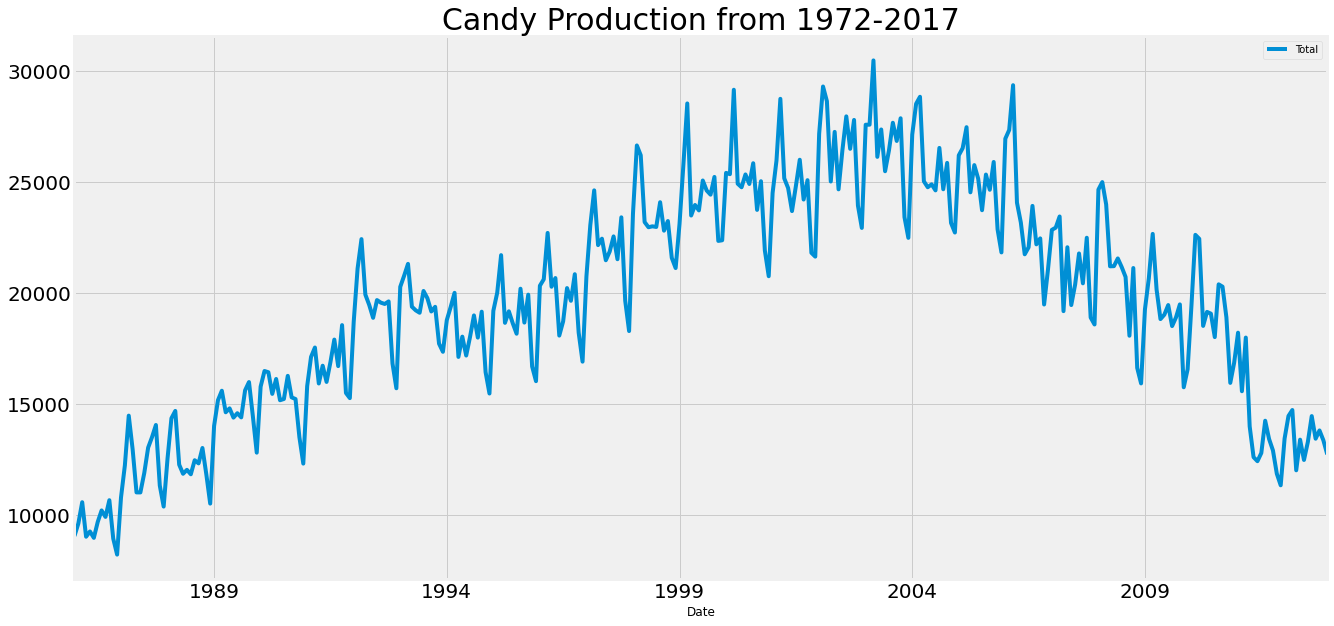

In [7]:
df.plot(figsize=(20, 10), fontsize=20)
plt.title('Candy Production from 1972-2017', fontsize=30)
plt.show()

 # DICKEY FULLER TEST

## HO = (NULL) = TIME SERIES IS NON-STATIONARY
## H1 =(ALTERNATE) TIME SERIES IS STATIONARY IN NATURE 
### IF ADF Statistic < Critical value reject the null hypothesis
### IF ADF Statistic > Critical value fail to reject the null hypothesis

In [5]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [6]:
X = df["production"]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.887050
p-value: 0.338178
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570
Failed to Reject Ho - Time Series is Non-Stationary


<a id='exploration'></a>
## Data Exploration 
---
Looking at our time series there is an interesting trend that may be fixed with a square root transform if not for the large dip around 2007-2008. This trend is the result of business cycles and other exongenous variables that effect economic data. We can use a box-cox transformation to remove the trend. Next we can dif the time series to deal with trend and plot both that result, and the resulting ACF and PACF graph that it creates. 

#### Box Cox Transformation
The box cox transformation makes non-normal data normally distributed. We can pass it an argument for lambda to automatically perform a log transform, square root transform, or reciprocal transform. If we pass no argument for lambda it will tune automatically and return a lambda value. 

Lambda Value 1.2550906935610247


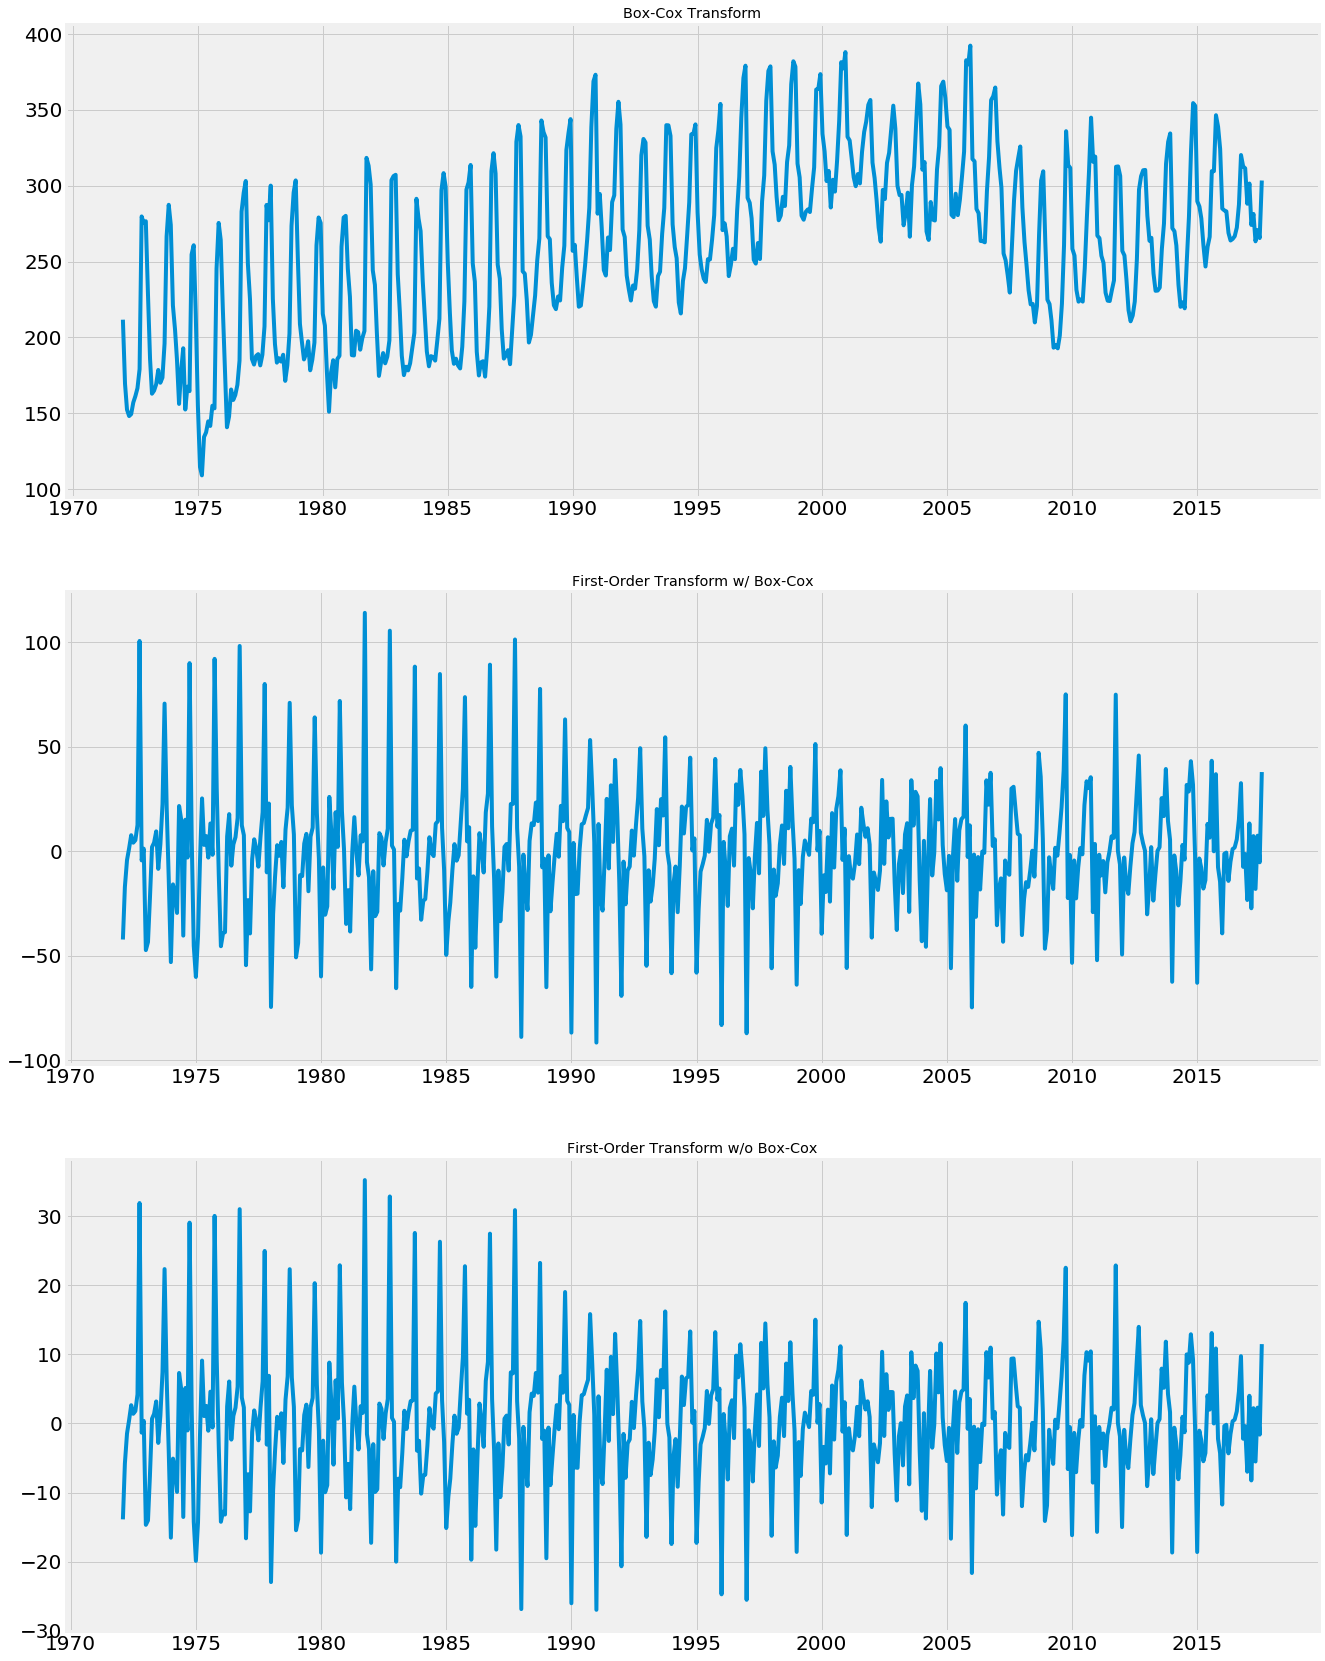

In [4]:
df['bc_production'], lamb = boxcox(df.production)
df['df1_production'] = df['bc_production'].diff()
df['df_production'] = df['production'].diff()
fig = plt.figure(figsize=(20,40))

bc = plt.subplot(411)
bc.plot(df.bc_production)
bc.title.set_text('Box-Cox Transform')
df1 = plt.subplot(412)
df1.plot(df.df1_production)
df1.title.set_text('First-Order Transform w/ Box-Cox')
df2 = plt.subplot(413)
df2.plot(df.df_production)
df2.title.set_text('First-Order Transform w/o Box-Cox')

df.bc_production.dropna(inplace=True)
df.df1_production.dropna(inplace=True)
df.df_production.dropna(inplace=True)

print(f'Lambda Value {lamb}')

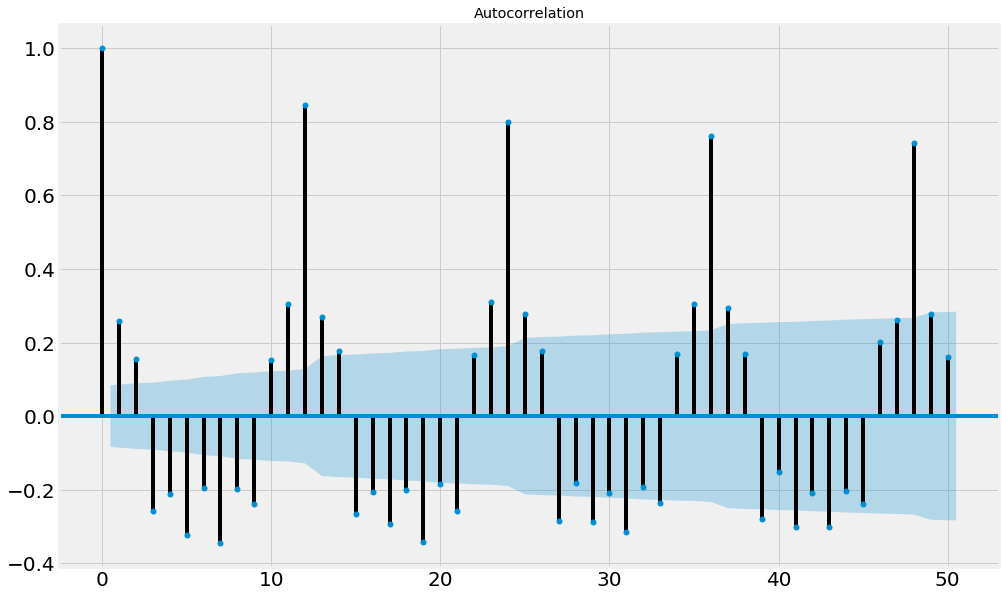

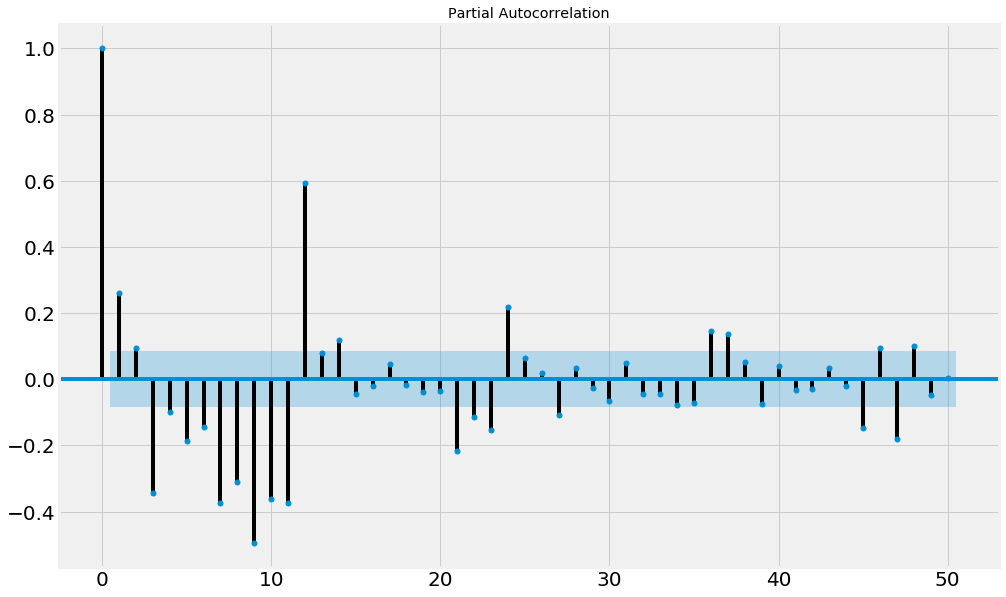

In [7]:
f_acf = plot_acf(df['df_production'], lags=50)
f_pacf = plot_pacf(df['df_production'], lags=50, method='ols')
f_acf.set_figheight(10)
f_acf.set_figwidth(15)
f_pacf.set_figheight(10)
f_pacf.set_figwidth(15)
plt.show()

<a id='estimation'></a>
## Parameter Estimation
---
After the box-cox transformation and differencing we no longer have a trend but the seasonality is still present and irregular. Becuase our lambda value is close to 1 (no transform) and the box-cox transformation didn't appear to make an important difference in the series, I've decided to drop it and the ACF and PACF plots reflect an untransformed series. We can use the ACF and PACF plots to determine the correct parameters for our SARIMA model. 

First, looking at the ACF we have a m value of 12, given that our greatest autocorrelation is at lag number 12, which makes since given our original plot and that this is monthly data. 

Given that m is positive that would indicate that P = 1, and Q = 0. Looking at the ACF and PACF plots both have their first significant lag at 1. So p = 1, and q = 1. Because we differenced the series d will also be 1. So we have parameters of: 
`SARIMA(1,1,1)(1,0,0)[12]`

We will split our data into a training and test set and then fit our SARIMA model.

In [26]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = df[start_date:end_date]
lim_catfish_sales.loc['1998-12-01'] = 10000

<ipython-input-26-bcded778603e>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



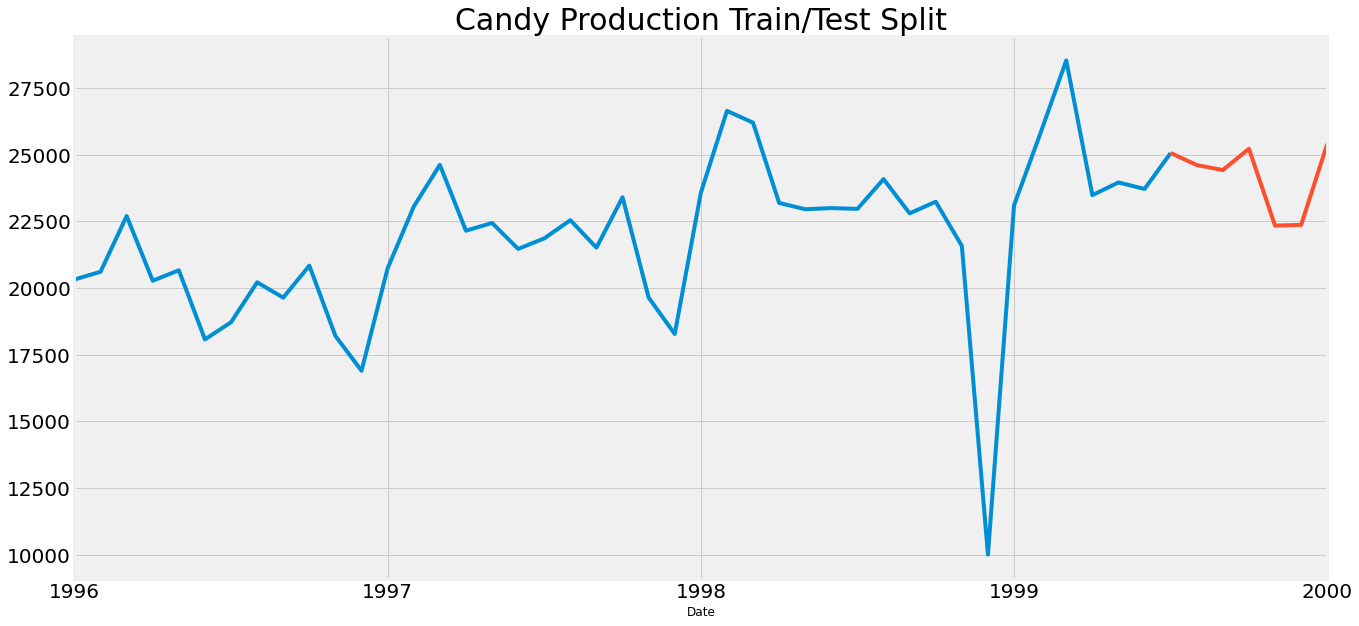

In [27]:
split_date = '1999-07-01'
train = lim_catfish_sales['Total'].loc[:split_date]
test = lim_catfish_sales['Total'].loc[split_date:]
train.plot(figsize=(20, 10), fontsize=20)
plt.title('Candy Production Train/Test Split', fontsize=30)
test.plot()
plt.show()

In [28]:
model = SARIMAX(train, freq='MS', order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
model_fit = model.fit(disp=False) 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



<a id='measurement'></a>
## Model Measurements
---
#### Scale-dependent Errors
Scale dependent errors are errors on the same scale as the data. 
    - Mean Squared Error (MAE): Popular and easy to understand
    - Root Mean Squared Error (RMSE)
    
#### Percentage Errors
Percentage errors are unit free and are frequently used to compare forecast performace between data sets. The percentage erros are typically some form of the estimated_value/ true_value. The downside to percentage errors is that they can lead to infinite or undefined values when the true value is zero. Also, when data is without a meaningful zero, like temperature, the combination of division and then absolute value, like in MAPE, can lead to errors that don't capture the true difference. 
    - Mean absolute percentage error (MAPE)
    - Symmetric MAPE: Deals with MAPE's tendency to put a heavier penalty on negative errors

#### Scaled Errors
Scaled errors are an attempt to get around some of the problems with percentage errors. 
    - Mean absolute scaled error (MASE)

Mean Squared Error: 4119366.3702902286
Root Mean Squared Error: 2029.6222235406835
Mean Absolute Error: 1336.9373056311076


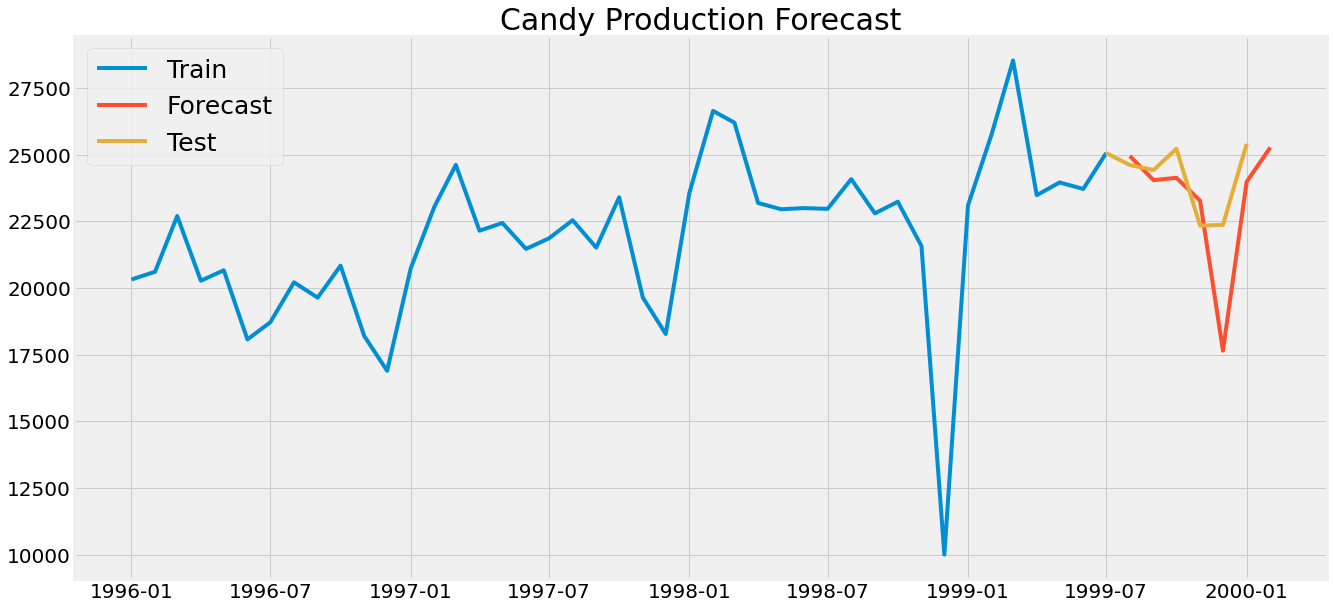

In [29]:
fcast_len = len(test)
fcast = model_fit.forecast(fcast_len)
mse = mean_squared_error(test, fcast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, fcast)
plt.figure(figsize=(20, 10))
plt.title('Candy Production Forecast', fontsize=30)
plt.plot(train, label='Train')
plt.plot(fcast, label='Forecast')
plt.plot(test, label='Test')

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
plt.legend(fontsize=25)
plt.show()

<a id='evaluation'></a>
## Model Evaluation
---
Unfortunately our model is not fitting the trend very well. The problem with the candy forecast data is that it has an unstable trend. What we could do next is decompose the trend from the rest of the time series with a Hodrick-Prescott Filter, a bandpass filter that was created for dealing with business cycles in economic data. 

Instead, we'll use a **rolling forecast**. A rolling forecast is where we forecast one step ahead and then refit our model on the new data, adding data from the test set. It's expensive because the model is refit every timestep but it allows us to forecast where a bad step will add to the overal error without effecting future forecasts. This means that early deviations from the time series because of the trend won't hurt our ability to forecast future steps. 

In [30]:
def rolling_forecast(train, test, order, season):
    history = [x for x in train]
    model = SARIMAX(history, order= order, seasonal_order= season)
    model_fit = model.fit(disp=False)
    predictions = []
    results = {}
    yhat = model_fit.forecast()[0]

    predictions.append(yhat)
    history.append(test[0])
    for i in range(1, len(test)):
        model = SARIMAX(history, order= order, seasonal_order= season)
        model_fit = model.fit(disp=False)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        obs = test[i]
        history.append(obs)
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    rmse = math.sqrt(mse)
    predictions = pd.Series(predictions, index=test.index)
    results['predictions'] = predictions
    results['mse'] = mse
    results['rmse'] = rmse
    results['mae'] = mae
    return results

In [31]:
rolling_fcast = rolling_forecast(train, test, (0, 1, 0), (1, 0, 1, 12))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Mean Squared Error: 8874819.348263266
Root Mean Squared Error: 2979.063501884991
Mean Absolute Error: 1635.7526185853962


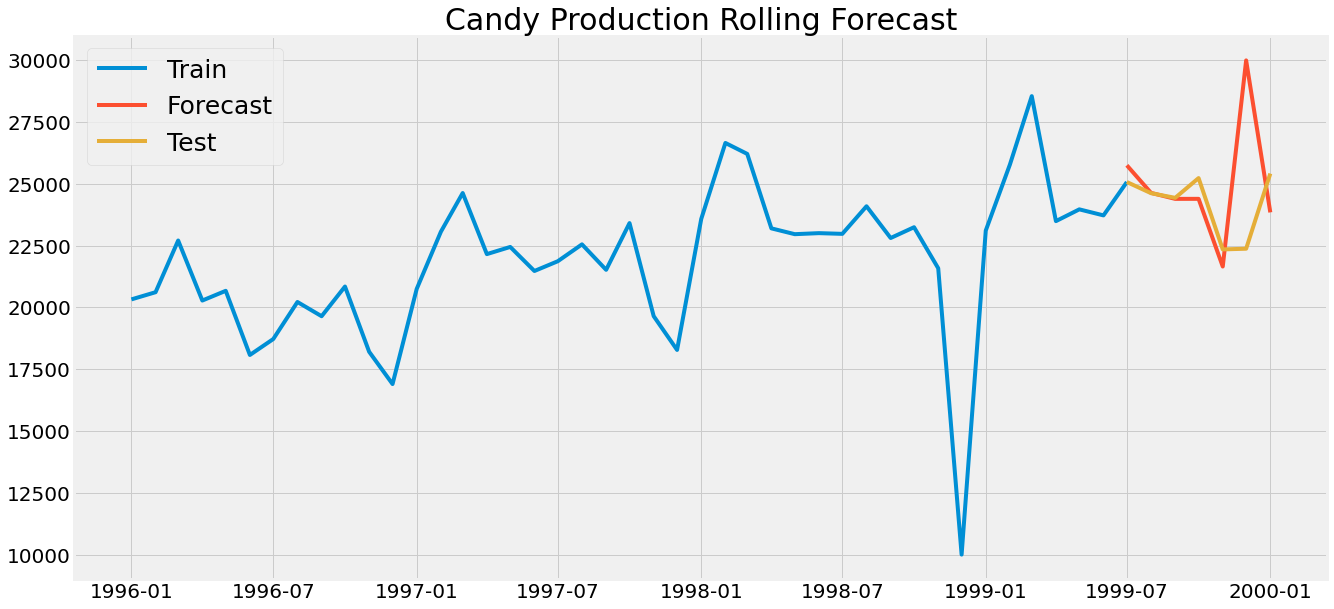

In [32]:
plt.figure(figsize=(20, 10))
plt.title('Candy Production Rolling Forecast', fontsize=30)
plt.plot(train, label='Train')
plt.plot(rolling_fcast['predictions'], label='Forecast')
plt.plot(test, label='Test')

print(f'Mean Squared Error: {rolling_fcast["mse"]}')
print(f'Root Mean Squared Error: {rolling_fcast["rmse"]}')
print(f'Mean Absolute Error: {rolling_fcast["mae"]}')
plt.legend(fontsize=25)
plt.show()